# CRAFTY: Clustering and scRAping For biTcoin deanonYmization

Il progetto è presentato sotto forma di notebook, integrando al codice una relazione che spiega i vari passi.

Qui di seguito ci sono le librerie utilizzate con relativi `import`.


In [1]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import requests
import time
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By

### lettura dei file .csv che compongono il dataset

Inizialmente vengono importati i vari file `.csv` che fanno parte della sottocartella della directory corrente `craftyDataset/2013`. Oltre ad importarli, vengono già modificati il dataset `tx` trasformando tutte le date della colonna `ts` (timestamp) in date facilmente leggibili, e il dataset `mapping` utilizzando la colonna `addressId` come indice (servirà per facilitare la deanonimizzazione)


In [2]:
# elenco delle transizioni
tx = pd.read_csv(
    "transactions.csv",
    names=["ts", "blkID", "txId", "isCoinbase", "fee"],
)

# converto il campo timestamp in una data leggibile
tx["ts"] = pd.to_datetime(tx["ts"], unit="s")

# elenco degli inputs delle transizioni
inp = pd.read_csv("inputs.csv", names=["txId", "prevTxId", "prevTxPos"])

# elenco degli outputs
out = pd.read_csv(
    "outputs.csv",
    names=["txId", "position", "addressId", "amount", "scriptType"],
)

# file che mappa gli indirizzi unici con gli hash
mapping = pd.read_csv("mappings.csv", names=["hash", "addressId"])
mapping.set_index("addressId", inplace=True)

## Analisi sul dataset

### 1) distribuzione del numero di transizioni per blocco (occupazione del blocco nell'intero periodo temporale considerato)

Quest' analisi si basa sul raggruppare le transizioni sul campo `blkID` e contare quante transizioni ci sono per blocco mediante la funzione `size()`.


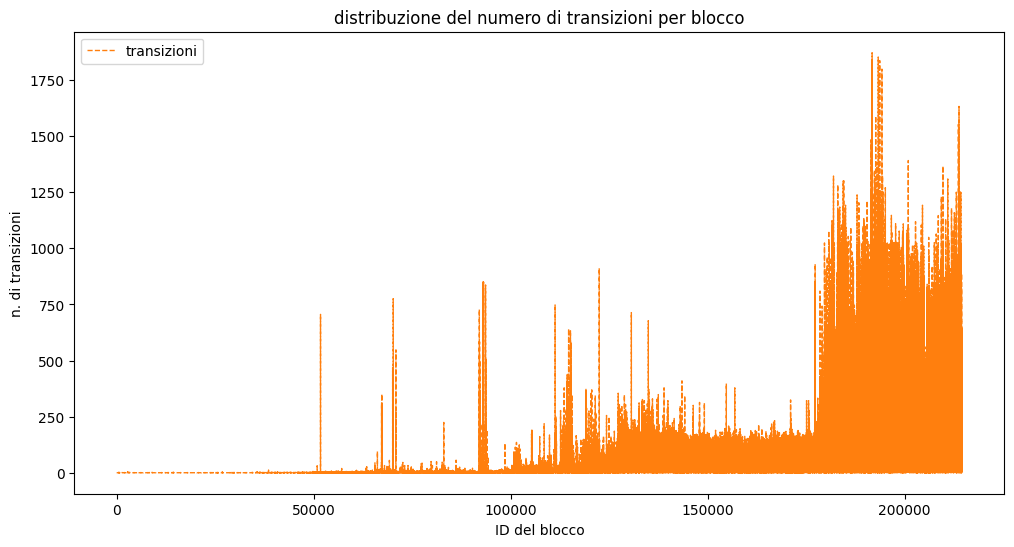

In [3]:
txDistr = tx.groupby("blkID").size()  # numero di transazioni per blocco

plt.figure(figsize=(12, 6))
plt.plot(
    txDistr.index, txDistr.values, color="tab:orange", linestyle="dashed", linewidth=1
)

plt.xlabel("ID del blocco")
plt.ylabel("n. di transizioni")
plt.title("distribuzione del numero di transizioni per blocco")
plt.legend(["transizioni"])
plt.show()

### 2) evoluzione dell'occupazione dei blocchi nel tempo considerando intervalli temporali di due mesi. In questo caso produrre un grafico che riporti il numero di transazioni medie per ogni periodo considerato.

Creo una lista contenente le date di riferimento per intervalli di tempo lunghi 2 mesi, cosi da poter usare la funzione `between()` per includere tutte le transizioni effettuate in quell'intervallo (`twoMonthDate[i]` e `twoMonthDate[i+1]`). Le liste contengono le transazioni effettuate nel bimestre di ogni anno per tutti e 4 gli anni. Per il plot uso un grouped bar plot in modo da visualizzare per ogni anno tutti gli intervalli bimestrali.


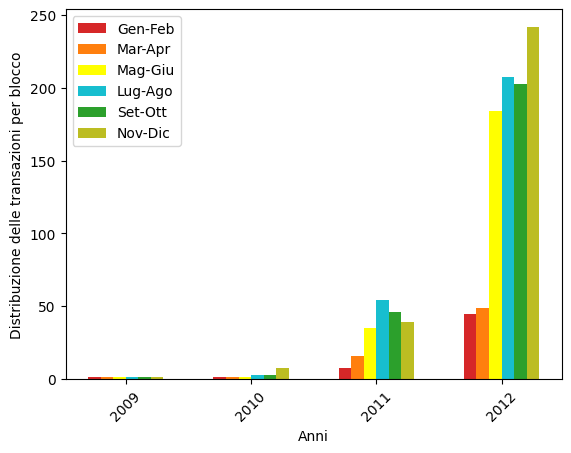

In [4]:
twoMonthsDate = pd.date_range(start="2009-01-01", end="2013-01-01", freq="2MS")

jan_feb = list()
mar_apr = list()
may_jun = list()
jul_aug = list()
sep_oct = list()
nov_dec = list()

for i in range(0, len(twoMonthsDate) - 1):
    daysBetweenDate = tx[tx["ts"].between(twoMonthsDate[i], twoMonthsDate[i + 1])]
    meanDistr = daysBetweenDate.groupby(["blkID"]).size().mean()
    if twoMonthsDate[i].month_name() == "January":
        jan_feb.append(meanDistr)
    elif twoMonthsDate[i].month_name() == "March":
        mar_apr.append(meanDistr)
    elif twoMonthsDate[i].month_name() == "May":
        may_jun.append(meanDistr)
    elif twoMonthsDate[i].month_name() == "July":
        jul_aug.append(meanDistr)
    elif twoMonthsDate[i].month_name() == "September":
        sep_oct.append(meanDistr)
    elif twoMonthsDate[i].month_name() == "November":
        nov_dec.append(meanDistr)


x = np.array([1, 2, 3, 4])
width = 0.1


bar1 = plt.bar(x - 2 * width, jan_feb, width, color="tab:red")
bar2 = plt.bar(x - 1 * width, mar_apr, width, color="tab:orange")
bar3 = plt.bar(x, may_jun, width, color="yellow")
bar4 = plt.bar(x + 1 * width, jul_aug, width, color="tab:cyan")
bar5 = plt.bar(x + 2 * width, sep_oct, width, color="tab:green")
bar6 = plt.bar(x + 3 * width, nov_dec, width, color="tab:olive")
plt.xticks(x + 0.5 * width, [2009, 2010, 2011, 2012])
plt.xlabel("Anni")
plt.ylabel("Distribuzione delle transazioni per blocco")
plt.xticks(rotation=45)
plt.legend(["Gen-Feb", "Mar-Apr", "Mag-Giu", "Lug-Ago", "Set-Ott", "Nov-Dic"])
plt.show()

### 3) ammontare totale degli UTXO al momento dell'ultima transizione registrata nella blockchain considerata

Ogni transizione può contentere più input/output, quindi per calcolare la somma degli UTXO devo tener traccia della posizione di ogni output per fare una `merge()` e ottenere gli output spesi. Per ottenere la somma degli UTXO sottraggo al totale degli `amount` degli output gli `amount` degli output spesi (contenuti nel merge fatto in precedenza)


UTXO: 859303372614879 BTC


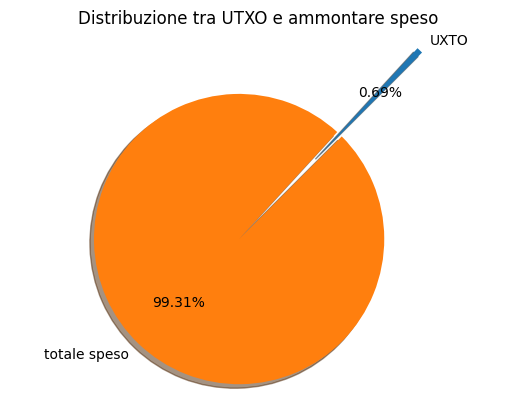

In [5]:
txSpent = out.merge(
    inp, right_on=["prevTxId", "prevTxPos"], left_on=["txId", "position"]
)

utxo = out["amount"].sum() - txSpent["amount"].sum()
print(f"UTXO: {utxo} BTC")

explode = (0.8, 0)
plt.pie(
    [utxo, txSpent["amount"].sum()],
    explode=explode,
    labels=["UXTO", "totale speso"],
    autopct="%.2f%%",
    shadow="True",
    startangle=45,
)
plt.axis("equal")
plt.title("Distribuzione tra UTXO e ammontare speso")
plt.show()

### 4) distribuzione degli intervalli di tempo che intercorrono tra la transazione che genera un output e quella che lo consuma, per gli output spesi nel periodo considerato

Inizio con il fare due merge, utili a capire quando il valore preso in input di una transizione viene generato e quando viene speso. Il primo viene ottenuto mediante una merge tra `output` e `tx`, l'altro su `input` e sempre `tx`. Si fa un terzo merge tra le due generate per ottenere la differenza di tempo in giorni tra `spentDate` e `creationDate` per ciascuna transizione, eliminando alcune colonne che potrebbero essere `Null` con la funzione `dropna()` (succede nel caso degli output non spesi).
Infine si raggruppa in base al numero di giorni di differenza e si calcolano le transazioni che hanno tale differenza di giorni. Si crea un nuovo dataset che contiene tali informazioni e si plotta utilizzando una scala logaritmica per quanto riguarda il numero di transizioni.


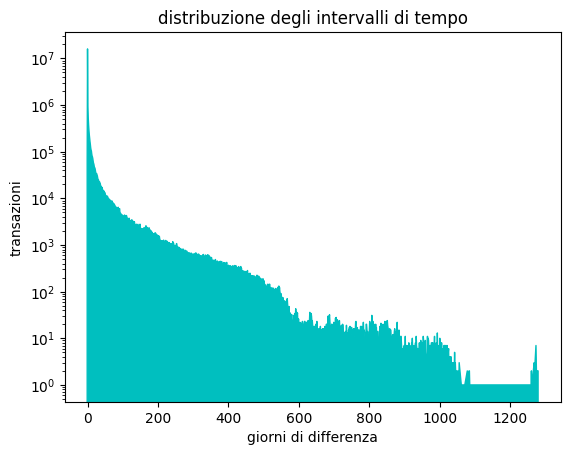

In [6]:
spentTX = inp.merge(tx, on="txId").rename(columns={"ts": "spentDate"})[
    ["prevTxId", "prevTxPos", "spentDate"]
]
createdTX = out.merge(tx, on="txId").rename(columns={"ts": "creationDate"})[
    ["txId", "position", "blkID", "creationDate"]
]

timeRes = createdTX.merge(
    spentTX,
    how="left",
    left_on=["txId", "position"],
    right_on=["prevTxId", "prevTxPos"],
)[["txId", "blkID", "creationDate", "spentDate"]]
timeRes = timeRes.dropna()
timeRes["diffDays"] = (timeRes["spentDate"] - timeRes["creationDate"]).dt.days

groupByDiff = timeRes.groupby("diffDays")["txId"].size()
days = pd.Series(list(groupByDiff.index))
numberOfOut = pd.Series(list(groupByDiff.values))

timeDistr = pd.concat([numberOfOut, days], axis="columns", keys=["outputs", "days"])

plt.stackplot(timeDistr["days"], timeDistr["outputs"], color="c")
plt.xlabel("giorni di differenza")
plt.ylabel("transazioni")
plt.yscale(value="log")

plt.title("distribuzione degli intervalli di tempo")
plt.show()

### Distribuzione fee nulle e positive per ogni transazione, raggruppate per anno

Ricavo le transazioni che hanno `fee` positive e quelle che hanno `fee` uguale a 0. Vengono raggruppate per anno e calcolo il numero delle rispettive transazioni che le contengono per anno. Plottando in questo modo vedo l'andamento tra le due tipologie di fee, avendo un'idea di quante hanno `fee` positive e quante nulle.


Fee positive per anno: ts
2009         10
2010       1304
2011     634809
2012    6571654
dtype: int64

Fee nulle per anno: ts
2009      10955
2010     167939
2011    1265272
2012    1880172
dtype: int64



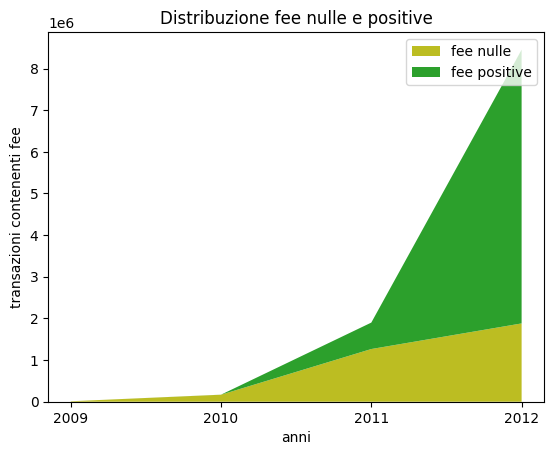

In [7]:
posFee = tx.loc[tx["fee"] > 0]
nullFee = tx.loc[tx["fee"] == 0]

posFeeGrouped = posFee.groupby(posFee["ts"].dt.year).size()
print(f"Fee positive per anno: {posFeeGrouped}\n")
nullFeeGrouped = nullFee.groupby(nullFee["ts"].dt.year).size()
print(f"Fee nulle per anno: {nullFeeGrouped}\n")


plt.title("Distribuzione fee nulle e positive")
plt.xlabel("anni")
plt.ylabel("transazioni contenenti fee")
plt.xticks([2009, 2010, 2011, 2012])
plt.stackplot(
    [2009, 2010, 2011, 2012],
    nullFeeGrouped,
    posFeeGrouped,
    colors=["tab:olive", "tab:green"],
)
plt.legend(["fee nulle", "fee positive"])
plt.show()

## Clusterizzazione degli indirizzi di Bitcoin

Abbiamo bisogno di un dataset che contenga l'`addressId` delle transazioni generate, ottenibile
facendo un merge tra input e output (`mergeInpOutTX`).

Calcolo il numero di input per ciascuna transizione per eliminare le transizioni che hanno 1 o 0
input, non utili alla nostra analisi.

In `addressTX` ho una lista che ha come "indice" l'ID della transizione, e come valore una lista
di tutti gli indirizzi degli input.

A questo punto, l'algoritmo di `address clustering` consiste nel:

- inserire tutti i nodi, ovvero gli indirizzi che sono all'interno del file mapping
- per ogni lista contenuta in addressTX
  - inserisco il primo elemento della lista all'interno del grafo e lo collego a tutti gli altri
    nodi presenti nella stessa lista (solo se non è già presente)
- si calcolano le componenti connesse con la funzione `nx.connected_component()`

Si prendono i cluster con il numero di indirizzi maggiori, li trasformo da indirizzi unici ad
indirizzi hash e trovo alcune informazioni che possono servire.


Numero di cluster: 4800614

Dimensione media dei cluster: 1.8141056539850944

Dimensione minima: 1

Dimensione massima: 259773

Dimensione dei 10 cluster più grandi: [259773, 121464, 99645, 76923, 40969, 30916, 26615, 20136, 19894, 16977]



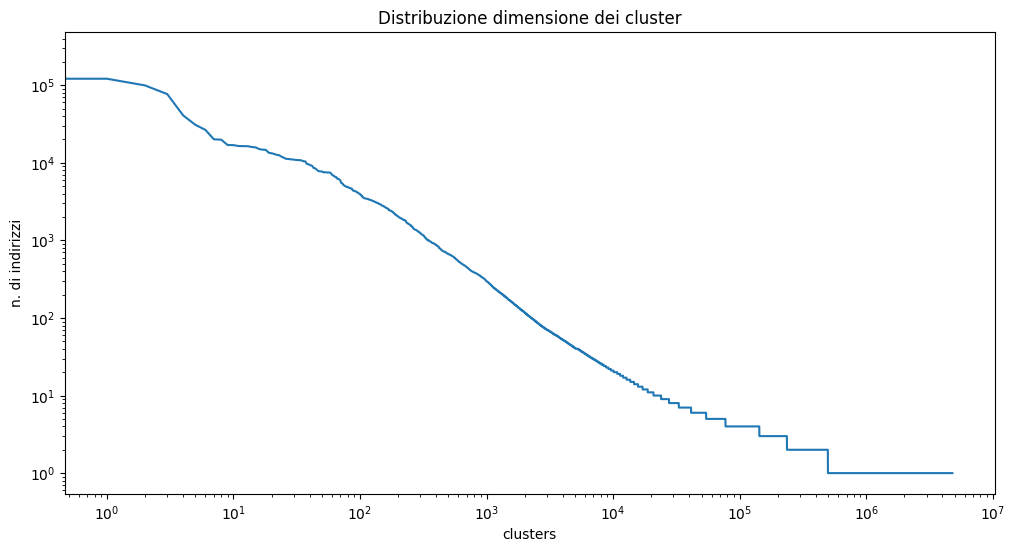

In [8]:
graphAddressTX = nx.Graph()

mergeInpOutTX = inp.merge(
    out, left_on=["prevTxId", "prevTxPos"], right_on=["txId", "position"]
).rename(columns={"txId_x": "txId"})[["txId", "prevTxId", "addressId"]]
nOfInputsTX = mergeInpOutTX.groupby("txId")["prevTxId"].size()

idGreater1 = np.greater(nOfInputsTX.values, 1)  # boolean
mergeInpOutTX = mergeInpOutTX.loc[
    mergeInpOutTX["txId"].isin((nOfInputsTX.loc[idGreater1]).index)
].reset_index(drop=True)

addressTX = mergeInpOutTX.groupby("txId")["addressId"].apply(list)

graphAddressTX.add_nodes_from(mapping.index)  # step 1

for listAddr in addressTX.values:  # step 2
    firstAddr = listAddr[0]
    for addr in listAddr[1:]:
        if firstAddr != addr and not (graphAddressTX.has_edge(firstAddr, addr)):
            graphAddressTX.add_edge(firstAddr, addr)

compGenerator = nx.connected_components(graphAddressTX)  # step 3
clusters = list(compGenerator)
sortedClst = sorted(clusters, key=len, reverse=True)
lenClst = [len(cluster) for cluster in sortedClst]

greater10Clst = sortedClst[:10]
greater10ClstSize = lenClst[:10]

# servirà per lo scraping
greater10ClstHash = [
    (mapping.loc[address]["hash"] for address in cluster) for cluster in greater10Clst
]

print(f"Numero di cluster: {len(sortedClst)}\n")
print(f"Dimensione media dei cluster: {sum(lenClst) / len(lenClst)}\n")
print(f"Dimensione minima: {lenClst[-1]}\n")
print(f"Dimensione massima: {lenClst[0]}\n")
print(f"Dimensione dei 10 cluster più grandi: {greater10ClstSize}\n")


plt.figure(figsize=(12, 6))
plt.title("Distribuzione dimensione dei cluster")
plt.xlabel("clusters")
plt.ylabel("n. di indirizzi")
plt.plot(lenClst, color="tab:blue")
plt.yscale(value="log")
plt.xscale(value="log")
plt.show()

## Web Scraping

In questa parte l'obiettivo è quello di riuscire a deanonimizzare più indirizzi possibili per
associare ad ogni cluster il relativo wallet a cui fa riferimento.

Per deanonimizzare vengono usati i due siti `Wallet Explorer` e `Bitcoin Info Charts`, ai quali mi
relaziono in modo differente.

Non cerco l'associazione per tutti gli indirizzi del cluster, ma ho un numero massimo di iterazioni,
in più appena trovo il primo indirizzo esco e passo al cluster successivo.

Viene fatto questo sia perchè ci metterebbe troppo tempo che per il fatto che il sito potrebbe
bloccare il nostro IP per il numero di richieste fatte e non deanonimizzare tutti i cluster.

Questo lo possiamo capire utilizzando lo status code: nel caso fosse `429` il sito ci avviserà che
stanno arrivando troppe richieste, non ottenendo più risposte.

### Wallet Explorer

Questo sito, oltre a deanonimizzare l'indirizzo, restituisce il numero di transazioni effettuate da
quell'indirizzo e il numero di indirizzi ad esso collegati.

Osservando la pagina HTML il nome del wallet associato all'indirizzo è presente nel tag `h2`.

Inizialmente quindi, per accedere alla pagina facciamo la request con la funzione `get()`
aggiungendo la query con parametro `q = addr`.

Utilizzando `BeautifulSoap`, attraverso la funzione `find()` possiamo accedere al primo tag `h2`
presente nella pagina.

La stringa che ci interessa si ottiene accedendo al campo `text`, prendendo in considerazione solo
il nome del wallet utilizzando la `split()`.

Una volta trovato, lo associamo all'interno di un oggetto contenente tutti i nomi dei 10 cluster
più grandi.

Quando non si riesce a deanonimizzare un indirizzo, al posto del nome del wallet vi è una sequenza
di numeri all'interno di parentesi quadre e nell'oggetto come nome del cluster rimarrà
`'Unknown wallet name'`.


In [9]:
# Wallet Explorer

headerAgents = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
    + " (KHTML, like Gecko) Chrome/61.0.3163.100Safari/537.36"
}
wexUrl = "https://www.walletexplorer.com/"


def scraperWallet(cluster, walletDict, value):
    nIteration = 15
    clstFound = False
    for addrCount, addr in enumerate(cluster, start=1):
        time.sleep(3)
        if addrCount > nIteration or clstFound:
            break
        walletDict[f"{value} cluster"] = "Unknown wallet name"

        request = requests.get(wexUrl, {"q": addr}, headers=headerAgents)
        if request.status_code == 429:
            print("Troppe richieste...")
            break
        html = request.text
        bs = BeautifulSoup(html, "html.parser")
        walletName = bs.find("h2")

        if walletName is not None:
            walletName = walletName.text.split(" ")[1]
            if walletName[0] != "[":
                clstFound = True
    if clstFound:
        walletDict[f"{value} cluster"] = walletName


walletDict = {}
clstNum = 1
for clst in greater10ClstHash:
    scraperWallet(clst, walletDict, clstNum)
    clstNum += 1

print(walletDict)

{'1 cluster': 'CoinJoinMess', '2 cluster': 'SilkRoadMarketplace', '3 cluster': 'Unknown wallet name', '4 cluster': 'Instawallet.org', '5 cluster': 'Unknown wallet name', '6 cluster': 'BTC-e.com-old', '7 cluster': 'BtcDice.com', '8 cluster': 'Unknown wallet name', '9 cluster': 'Unknown wallet name', '10 cluster': 'Unknown wallet name'}


### Bitcoin Info Charts

Nel caso di Bitcoin Info Charts, la pagina di interesse non contiene solo la query, ma bisogna
concatenare tra la home del sito e l'indirizzo che vogliamo cercare la stringa `bitcoin/address/`.

Inoltre, non userò nuovamente `BeautifulSoup` ma `Selenium`, con il quale automatizzerò il processo
di ricerca mediante il driver del browser (in questo caso Chrome).

Sempre per evitare di essere bloccati e respinti dal sito, utilizzo delle `sleep()` e limito il
numero di indirizzi.

In questa pagina html, il nome del wallet è contenuto all'interno del tag `small`. Cerco il tag che
contiene il testo con il nome, controllo se non è un valore che contiene solo cifre, lo estraggo e
lo assegno al cluster sempre all'interno di un oggetto.


In [10]:
# Bitcoin Info Charts

btcUrl = "https://bitinfocharts.com/"


def scraperBTCinfoCharts(cluster, BTCDict, value):
    nIteration = 10
    clstFound = False
    for addrCount, addr in enumerate(cluster, start=1):
        time.sleep(3)
        if addrCount > nIteration or clstFound:
            break

        driver = webdriver.Chrome()
        driver.get(btcUrl + "bitcoin/address/" + addr)

        for smallTag in driver.find_elements(By.TAG_NAME, "small"):
            if ":" not in smallTag.text:
                continue

            walletName = smallTag.text.split(": ")[1]
            if not walletName.isdigit():
                clstFound = True

        driver.quit()

    if clstFound:
        BTCDict[f"{value} cluster"] = walletName
    else:
        BTCDict[f"{value} cluster"] = "Unknown wallet name"


clstNum = 1
btcDict = {}
for clst in greater10ClstHash:
    scraperBTCinfoCharts(clst, btcDict, clstNum)
    clstNum += 1


print(btcDict)

KeyboardInterrupt: 

## Conclusioni

Con le due analisi abbiamo due deanonimizzazioni differenti, date probabilmente da algoritmi diversi usati dai due siti. Da `Wallet Explorer` abbiamo i seguenti cluster:

- cluster 1 -> CoinJoinMess
- cluster 2 -> SilkRoadMarketplace
- cluster 3 -> Unknown wallet name
- cluster 4 -> Instawallet.org
- cluster 5 -> Unknown wallet name
- cluster 6 -> BTC-e.com-old
- cluster 7 -> BtcDice.com
- cluster 8 -> Unknown wallet name
- cluster 9 -> Unknown wallet name
- cluster 10 -> Unknown wallet name

Per `Bitcoin Info Charts` invece abbiamo i seguenti:

- cluster 1 -> F2Pool
- cluster 2 -> SilkRoadMarketplace
- cluster 3 -> Unknown wallet name
- cluster 4 -> Instawallet.org
- cluster 5 -> Unknown wallet name
- cluster 6 -> Eligius
- cluster 7 -> Unknown wallet name
- cluster 8 -> Unknown wallet name
- cluster 9 -> Unknown wallet name
- cluster 10 -> Unknown wallet name

Abbiamo che i cluster 1 e 6 sono de-anonimizzati in modo diverso, probabilmente per euristica usata o mancato aggiornamento del sito con indirizzi più recenti, mentre il cluster 7 su `Bitcoin Info Charts` non è stato possibile de-anonimizzarlo, probabilmente per il numero di tentativi bassi.
